<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/schools8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit a hierarchical Bayesian model to the "8 schools" dataset.
See also https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

In [1]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [2]:
!pip install -qq -U pymc3>=3.8
try:
    import pymc3 as pm
except ModuleNotFoundError:
    %pip install -qq pymc3
    import pymc3 as pm
print(pm.__version__)
try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install -qq theano
    import theano.tensor as tt
import theano

#!pip install -qq arviz
try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

3.11.2


In [8]:
!mkdir ../figures

# Data

8.75
7.5


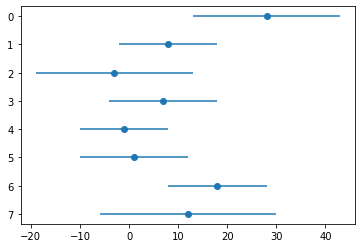

In [11]:
# https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
print(np.mean(y))
print(np.median(y))

names = []
for t in range(8):
    names.append("{}".format(t))

# Plot raw data
fig, ax = plt.subplots()
y_pos = np.arange(8)
ax.errorbar(y, y_pos, xerr=sigma, fmt="o")
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
plt.title("8 schools")
plt.savefig("../figures/schools8_data.png")
plt.show()

# Centered model

In [12]:
# Centered model
with pm.Model() as Centered_eight:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=5)
    sigma_alpha = pm.HalfCauchy("sigma_alpha", beta=5)
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=J)
    obs = pm.Normal("obs", mu=alpha, sigma=sigma, observed=y)
    log_sigma_alpha = pm.Deterministic("log_sigma_alpha", tt.log(sigma_alpha))

np.random.seed(0)
with Centered_eight:
    trace_centered = pm.sample(1000, chains=4, return_inferencedata=False)

pm.summary(trace_centered).round(2)
# PyMC3 gives multiple warnings about  divergences
# Also, see r_hat ~ 1.01, ESS << nchains*1000, especially for sigma_alpha
# We can solve these problems below by using a non-centered parameterization.
# In practice, for this model, the results are very similar.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.
There were 851 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6628857715123737, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1095 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1597 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6077663903532085, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1954 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6911675469130037, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems duri

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,4.40,3.42,-1.24,11.22,0.20,0.14,309.0,343.0,1.02
alpha[0],6.20,5.68,-3.60,17.14,0.26,0.18,343.0,9552.0,1.01
alpha[1],4.92,4.84,-3.85,14.16,0.24,0.17,382.0,10333.0,1.01
alpha[2],3.89,5.28,-5.98,13.98,0.17,0.12,757.0,9811.0,1.01
alpha[3],4.77,4.86,-4.23,14.03,0.18,0.13,614.0,9750.0,1.01
alpha[4],3.61,4.72,-5.24,12.28,0.18,0.14,591.0,533.0,1.01
alpha[5],4.05,4.85,-5.04,13.18,0.17,0.13,626.0,9685.0,1.01
alpha[6],6.34,5.13,-2.88,16.21,0.25,0.18,345.0,6866.0,1.01
alpha[7],4.85,5.31,-4.96,15.02,0.20,0.14,511.0,11132.0,1.01
sigma_alpha,3.69,3.16,0.43,9.19,0.20,0.14,66.0,15.0,1.05


In [5]:
# Display the total number and percentage of divergent chains
diverging = trace_centered["diverging"]
print("Number of Divergent Chains: {}".format(diverging.nonzero()[0].size))
diverging_pct = diverging.nonzero()[0].size / len(trace_centered) * 100
print("Percentage of Divergent Chains: {:.1f}".format(diverging_pct))

Number of Divergent Chains: 1954
Percentage of Divergent Chains: 19.5


In [19]:
dir(trace_centered)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attrs',
 '_report',
 '_slice',
 '_straces',
 'add_values',
 'chains',
 'get_sampler_stats',
 'get_values',
 'nchains',
 'point',
 'points',
 'remove_values',
 'report',
 'stat_names',
 'varnames']

In [20]:
trace_centered.varnames

['mu_alpha', 'sigma_alpha_log__', 'alpha', 'sigma_alpha', 'log_sigma_alpha']

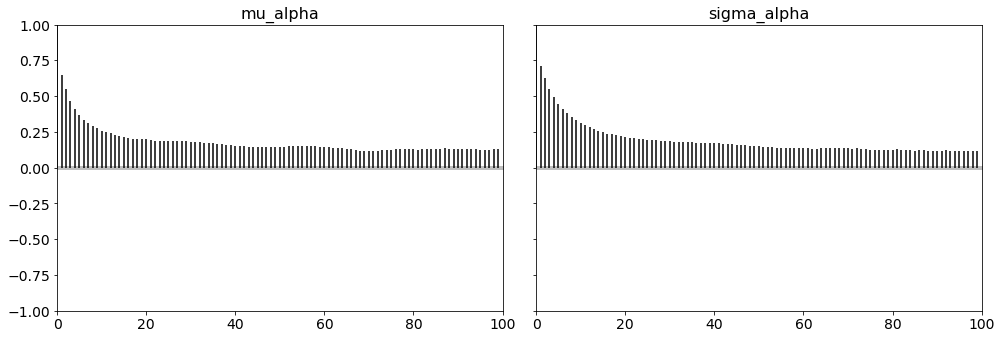

In [47]:
with Centered_eight:
    # fig, ax = plt.subplots()
    az.plot_autocorr(trace_centered, var_names=["mu_alpha", "sigma_alpha"], combined=True)
    plt.savefig("schools8_centered_acf_combined.png", dpi=300)

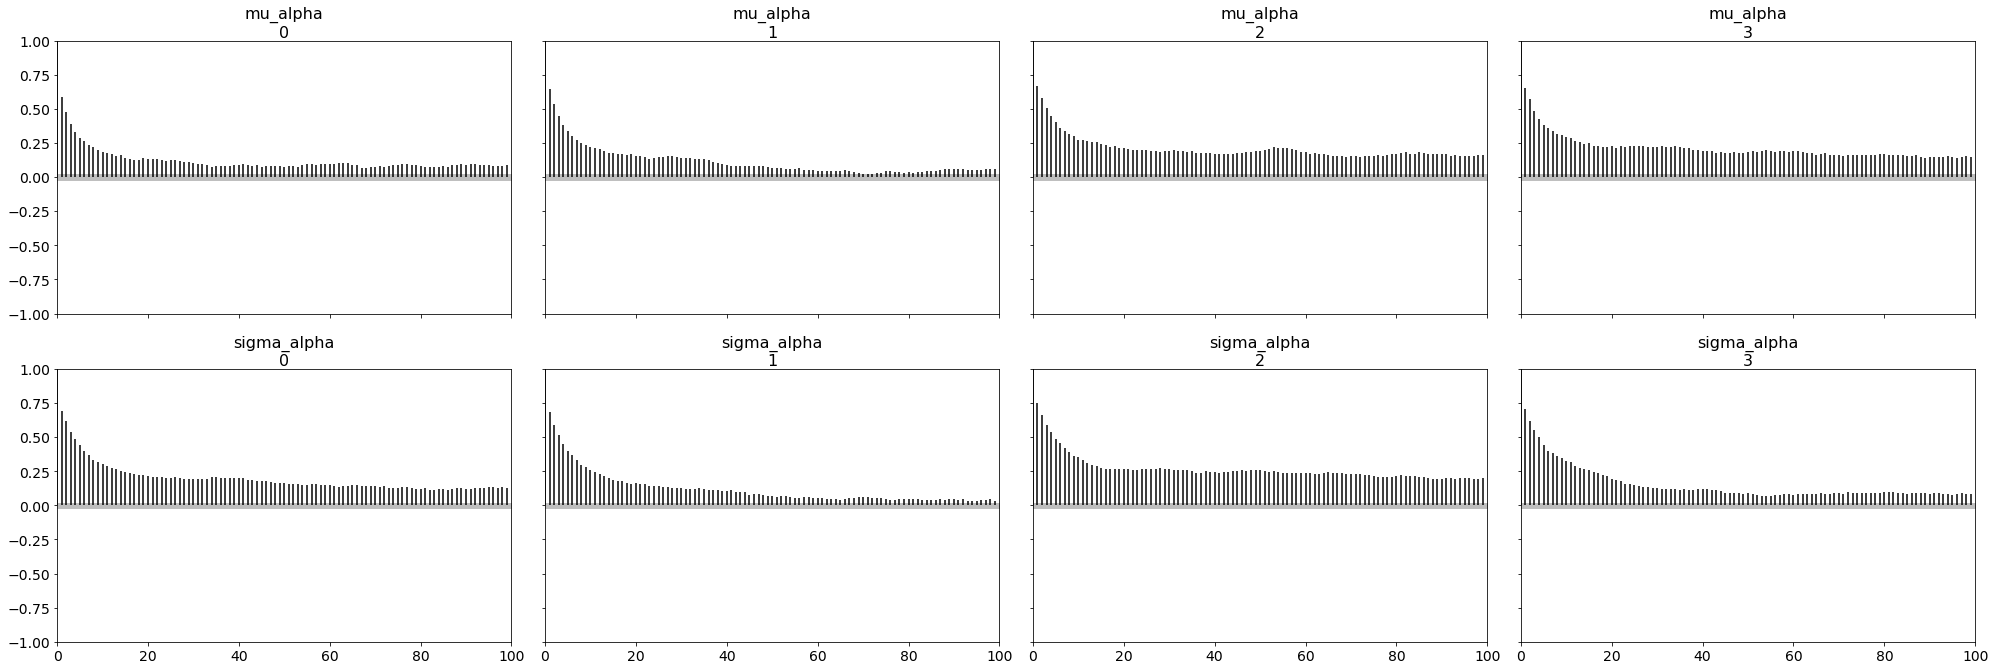

In [48]:
with Centered_eight:
    # fig, ax = plt.subplots()
    az.plot_autocorr(trace_centered, var_names=["mu_alpha", "sigma_alpha"])
    plt.savefig("schools8_centered_acf.png", dpi=300)

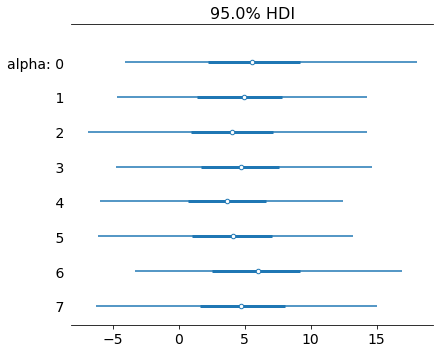

In [49]:
with Centered_eight:
    az.plot_forest(trace_centered, var_names="alpha", hdi_prob=0.95, combined=True)
    plt.savefig("schools8_centered_forest_combined.png", dpi=300)

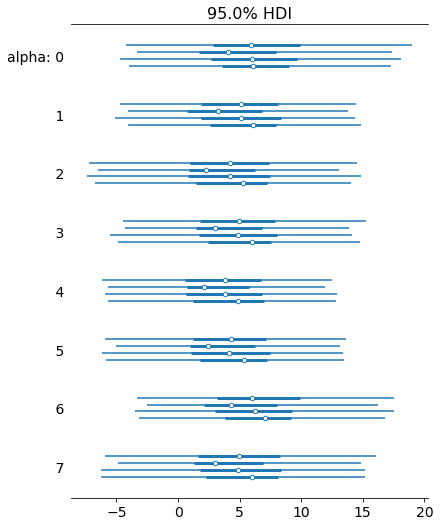

In [50]:
with Centered_eight:
    az.plot_forest(trace_centered, var_names="alpha", hdi_prob=0.95, combined=False)
    plt.savefig("schools8_centered_forest.png", dpi=300)

# Non-centered

In [32]:
# Non-centered parameterization

with pm.Model() as NonCentered_eight:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=5)
    sigma_alpha = pm.HalfCauchy("sigma_alpha", beta=5)
    alpha_offset = pm.Normal("alpha_offset", mu=0, sigma=1, shape=J)
    alpha = pm.Deterministic("alpha", mu_alpha + sigma_alpha * alpha_offset)
    # alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=J)
    obs = pm.Normal("obs", mu=alpha, sigma=sigma, observed=y)
    log_sigma_alpha = pm.Deterministic("log_sigma_alpha", tt.log(sigma_alpha))

np.random.seed(0)
with NonCentered_eight:
    trace_noncentered = pm.sample(1000, chains=4)

pm.summary(trace_noncentered).round(2)
# Samples look good: r_hat = 1, ESS ~= nchains*1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha_offset, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 54 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
There were 347 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,4.36,3.32,-2.08,10.49,0.02,0.01,30224.0,18431.0,1.0
alpha_offset[0],0.32,0.99,-1.58,2.13,0.00,0.00,35965.0,24380.0,1.0
alpha_offset[1],0.10,0.94,-1.60,1.93,0.00,0.00,40387.0,25132.0,1.0
alpha_offset[2],-0.08,0.97,-1.93,1.70,0.00,0.00,40215.0,26739.0,1.0
alpha_offset[3],0.07,0.94,-1.72,1.84,0.00,0.00,37724.0,24917.0,1.0
alpha_offset[4],-0.16,0.93,-1.91,1.58,0.00,0.00,36056.0,25243.0,1.0
alpha_offset[5],-0.08,0.94,-1.85,1.68,0.00,0.00,41375.0,26625.0,1.0
alpha_offset[6],0.37,0.96,-1.45,2.18,0.00,0.00,35574.0,24420.0,1.0
alpha_offset[7],0.07,0.97,-1.77,1.88,0.00,0.00,39905.0,27080.0,1.0
sigma_alpha,3.64,3.20,0.00,9.26,0.02,0.02,19136.0,16931.0,1.0


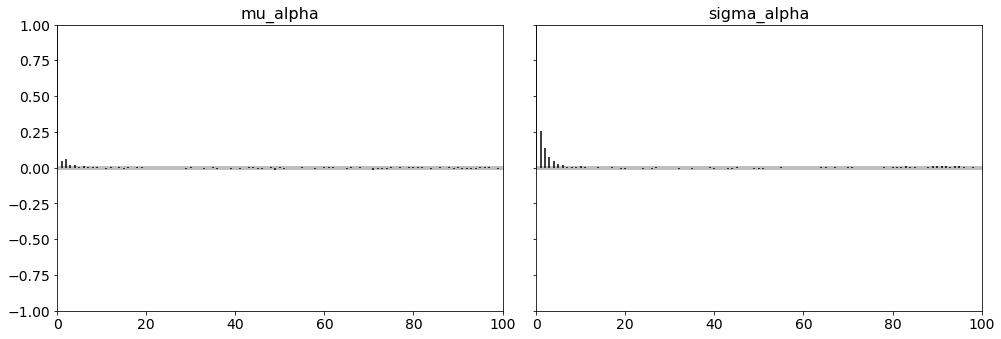

In [51]:
with NonCentered_eight:
    az.plot_autocorr(trace_noncentered, var_names=["mu_alpha", "sigma_alpha"], combined=True)
    plt.savefig("schools8_noncentered_acf_combined.png", dpi=300)

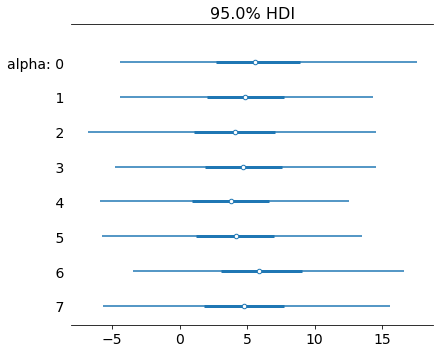

In [52]:
with NonCentered_eight:
    az.plot_forest(trace_noncentered, var_names="alpha", combined=True, hdi_prob=0.95)
    plt.savefig("schools8_noncentered_forest_combined.png", dpi=300)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


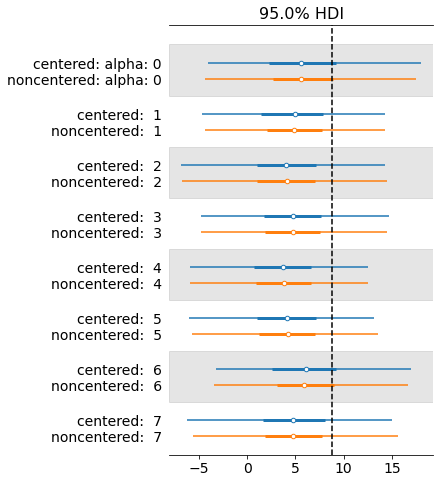

In [36]:
az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names="alpha",
    combined=True,
    hdi_prob=0.95,
)
plt.axvline(np.mean(y), color="k", linestyle="--")

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


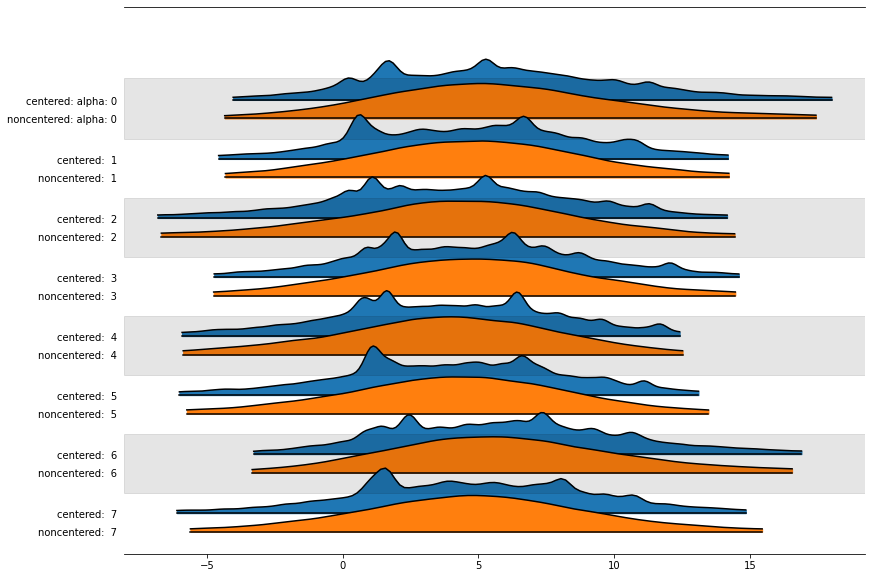

In [38]:
az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names="alpha",
    kind="ridgeplot",
    combined=True,
    hdi_prob=0.95,
);

# Funnel of hell

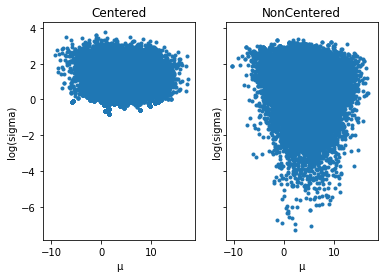

In [53]:
# Plot the "funnel of hell"
# Based on
# https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(trace_centered["mu_alpha"], name="mu_alpha")
y = pd.Series(trace_centered["log_sigma_alpha"], name="log_sigma_alpha")
axs[0].plot(x, y, ".")
axs[0].set(title="Centered", xlabel="µ", ylabel="log(sigma)")
# axs[0].axhline(0.01)

x = pd.Series(trace_noncentered["mu_alpha"], name="mu")
y = pd.Series(trace_noncentered["log_sigma_alpha"], name="log_sigma_alpha")
axs[1].plot(x, y, ".")
axs[1].set(title="NonCentered", xlabel="µ", ylabel="log(sigma)")
# axs[1].axhline(0.01)

plt.savefig("schools8_funnel.png", dpi=300)

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


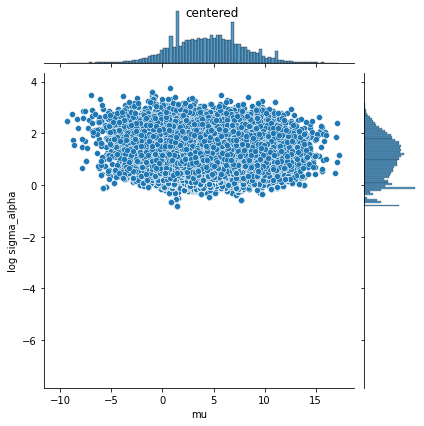

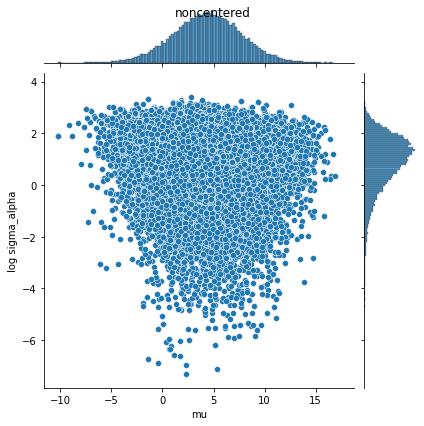

In [54]:
x = pd.Series(trace_centered["mu_alpha"], name="mu")
y = pd.Series(trace_centered["log_sigma_alpha"], name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("centered")
plt.savefig("schools8_centered_joint.png", dpi=300)

x = pd.Series(trace_noncentered["mu_alpha"], name="mu")
y = pd.Series(trace_noncentered["log_sigma_alpha"], name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("noncentered")
plt.savefig("schools8_noncentered_joint.png", dpi=300)

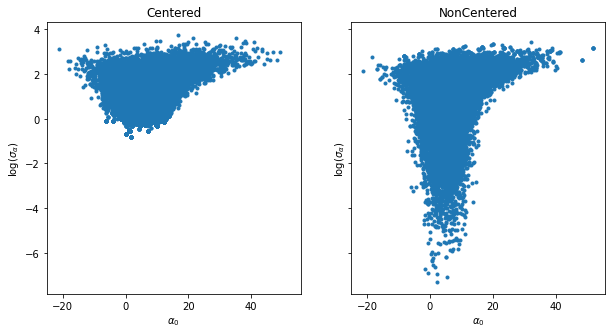

In [55]:
group = 0
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
x = pd.Series(trace_centered["alpha"][:, group], name=f"alpha {group}")
y = pd.Series(trace_centered["log_sigma_alpha"], name="log_sigma_alpha")
axs[0].plot(x, y, ".")
axs[0].set(title="Centered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

x = pd.Series(trace_noncentered["alpha"][:, group], name=f"alpha {group}")
y = pd.Series(trace_noncentered["log_sigma_alpha"], name="log_sigma_alpha")
axs[1].plot(x, y, ".")
axs[1].set(title="NonCentered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

plt.savefig("schools8_funnel_group0.png", dpi=300)